In [ ]:
import torch
from torchfsdd import TorchFSDDGenerator, TrimSilence
from torchaudio.transforms import MFCC, TimeMasking, FrequencyMasking
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from lightning import Trainer
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, RichModelSummary, RichProgressBar
from matplotlib import pyplot as plt
from pathlib import Path
import sys
import numpy as np
# quick hacky way to get the package visible in the notebook
base_path = Path(".").resolve().parent
sys.path.append(str(base_path ))

from sdc.rnn import RNN
from sdc.trainer import RNNTrainer
USE_GPU = torch.cuda.is_available() and 1
N_CLASSES = 10 # 0-9 digits
SAMPLING_RATE = 8e3  # 8kHz
N_MFCC_CHANNELS = 13  # Number of MFCC channels
MAX_EPOCHS = 50
DEVICE = torch.device("cuda") if USE_GPU else torch.device("cpu")
CHECKPOINT_PATH = Path(".") / "saved_models"
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)
EXPERIMENT_NAME = "small_rnn_model"
BATCH_SIZE = 4

# torch.set_default_device(DEVICE)
# torch.set_default_dtype(torch.float16)
torch.set_float32_matmul_precision("medium")
# torch.set_float32_matmul_precision("high")


# chop off silence from the beginning and end of the audio
trimmer = TrimSilence(threshold=1e-6)

mfcc = MFCC(sample_rate=SAMPLING_RATE, n_mfcc=N_MFCC_CHANNELS)

time_masking = TimeMasking(time_mask_param=2, p=0.3)
freq_masking = FrequencyMasking(freq_mask_param=2)
freq_masking.p = 0.3

# Fetch the latest version of FSDD and initialize a generator with those files
fsdd = TorchFSDDGenerator(version='master', transforms=None)

# Create three Torch datasets for a train-validation-test split from the generator
train_set, val_set, test_set = fsdd.train_val_test_split(test_size=0.15, val_size=0.15)



In [2]:
default_root_dir = CHECKPOINT_PATH / EXPERIMENT_NAME
default_root_dir.mkdir(parents=True, exist_ok=True)


In [3]:
mlf_logger = MLFlowLogger(
    experiment_name=EXPERIMENT_NAME,
    # tracking_uri=f"http://localhost:5000",
)

In [4]:
# Create a transformation pipeline to apply to the recordings
train_transforms = Compose([
    trimmer,
    mfcc,
    time_masking,
    freq_masking,
])

val_transforms = Compose([
    trimmer,
    mfcc,
])

train_set.transforms = train_transforms
val_set.transforms = val_transforms
test_set.transforms = val_transforms

In [5]:
def collate_fn(data):
    """Batch and pad wakeword data"""
    mfccs = []
    labels = []
    for d in data:
        mfcc, label = d
        mfccs.append(mfcc.squeeze(0).transpose(0, 1))
        labels.append(label)

    # pad mfccs to ensure all tensors are same size in the time dim
    mfccs = torch.nn.utils.rnn.pad_sequence(mfccs, batch_first=True)  # batch, seq_len, feature

    # print(mfccs.shape)
    labels = torch.asarray(labels)
    return mfccs, labels

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
)

In [6]:
rnn = RNN(
    lstm_config={
        'input_size': N_MFCC_CHANNELS,
        'hidden_size': 48,
        'num_layers': 1,
    },
    linear_sizes=[N_CLASSES],
)

rnn.to(DEVICE)

/home/chanokin/innatera/audio_digit_classifier/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


RNN(
  (lstm): LSTM(13, 48, batch_first=True, dropout=0.3)
  (linear_000): LSD(
    (linear): Linear(in_features=48, out_features=10, bias=True)
    (act): SiLU()
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [7]:
rnn_trainer = RNNTrainer(
    model=rnn,

)

rnn_trainer.to(DEVICE)

RNNTrainer(
  (model): RNN(
    (lstm): LSTM(13, 48, batch_first=True, dropout=0.3)
    (linear_000): LSD(
      (linear): Linear(in_features=48, out_features=10, bias=True)
      (act): SiLU()
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (loss_fn): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (train_accuracy): MulticlassAccuracy()
)

In [8]:
trainer = Trainer(
    default_root_dir=default_root_dir,
    accelerator="cuda" if USE_GPU else "cpu",
    # amp_type="apex",
    # max_epochs=30 if i == 0 else 10,
    max_epochs=MAX_EPOCHS,
    # strategy="ddp",
    callbacks=[
        ModelCheckpoint(),
        RichProgressBar(),
        LearningRateMonitor("epoch"),
        # PlotWeightsOnEpochEndCallback(),
        # PlotWeightsOnTrainStartCallback(),
        # EarlyStopping(monitor="val_acc", patience=8, mode="max"),
        RichModelSummary(max_depth=3),
    ],
    logger=mlf_logger,
)


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model=rnn_trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                     ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                    │ RNN                │ 12.6 K │ train │
│ 1 │ model.lstm               │ LSTM               │ 12.1 K │ train │
│ 2 │ model.linear_000         │ LSD                │    490 │ train │
│ 3 │ model.linear_000.linear  │ Linear             │    490 │ train │
│ 4 │ model.linear_000.act     │ SiLU               │      0 │ train │
│ 5 │ model.linear_000.dropout │ Dropout            │      0 │ train │
│ 6 │ loss_fn                  │ CrossEntropyLoss   │      0 │ train │
│ 7 │ accuracy                 │ MulticlassAccuracy │      0 │ train │
│ 8 │ train_accuracy           │ MulticlassAccuracy │      0 │ train │
└───┴──────────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 12.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 12.6 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 9                                                                                           
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


In [10]:
import mlflow

latest = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME], order_by=["start_time desc"], max_results=1, filter_string="status='FINISHED'")

print(latest)
# run = mlflow.get_run(run_id="fafb190425fa4fecb9ea61d292e9609a")

                             run_id       experiment_id    status  \
0  6ac40e30adfb4e908503de47d336668b  685926483429733056  FINISHED   

                                        artifact_uri  \
0  file:///home/chanokin/innatera/audio_digit_cla...   

                        start_time                         end_time  \
0 2025-05-03 15:27:44.460000+00:00 2025-05-03 15:38:26.310000+00:00   

   metrics.train_acc_step  metrics.val_acc  metrics.lr-Adam  \
0                     1.0         0.947619            0.001   

   metrics.train_loss_step  metrics.epoch  metrics.val_loss  \
0                  0.00626           49.0          0.313937   

   metrics.train_acc_epoch  metrics.train_loss_epoch tags.mlflow.user  \
0                 0.699537                  0.876346         chanokin   

                             tags.mlflow.source.name tags.mlflow.source.type  \
0  /home/chanokin/innatera/audio_digit_classifier...                   LOCAL   

   tags.mlflow.runName  
0  intelligent-rat

In [11]:
from torchmetrics import ConfusionMatrix

test_loader = DataLoader(
    test_set,
    batch_size=1024,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
)


confmat = ConfusionMatrix(task="multiclass", normalize='true', num_classes=N_CLASSES, ).to(DEVICE)
confmat.reset()


rnn.to(DEVICE)
rnn.eval()
for batch in test_loader:
    mfcc, label = batch
    mfcc = mfcc.to(DEVICE)
    label = label.to(DEVICE)

    with torch.no_grad():
        pred = rnn(mfcc)

    confmat.update(pred, label)


matrix = confmat.compute().cpu().numpy()



[0.97619045 0.85714287 0.97619045 0.95238096 0.88095236 1.
 0.64285713 0.97619045 0.7380952  0.88095236]


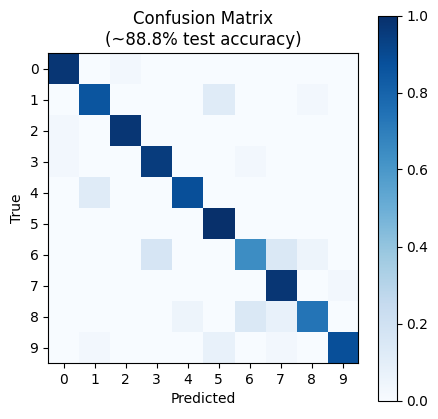

In [12]:

# get main diagonal
diag = matrix.diagonal()
print(diag)
# print(matrix)
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
ax.set_title(f"Confusion Matrix\n(~{100*diag.mean():.1f}% test accuracy)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(N_CLASSES))
ax.set_yticks(range(N_CLASSES))
ax.set_xticklabels(range(N_CLASSES))
ax.set_yticklabels(range(N_CLASSES))
plt.colorbar(im, ax=ax)
plt.show()

## Size/Accuracy stats

In [27]:
lstm_sizes = [128, 64, 48, 32]
params = [74.5, 20.9, 12.6, 6.3]
accuracies = {
    128: [95.0, 96.4],
    64: [92.3, 94.5],
    48: [95.0, 88.8],
    32: [86.2, 92.3],
}

avg_acc = [np.array(accuracies[k]) .mean() for k in lstm_sizes]


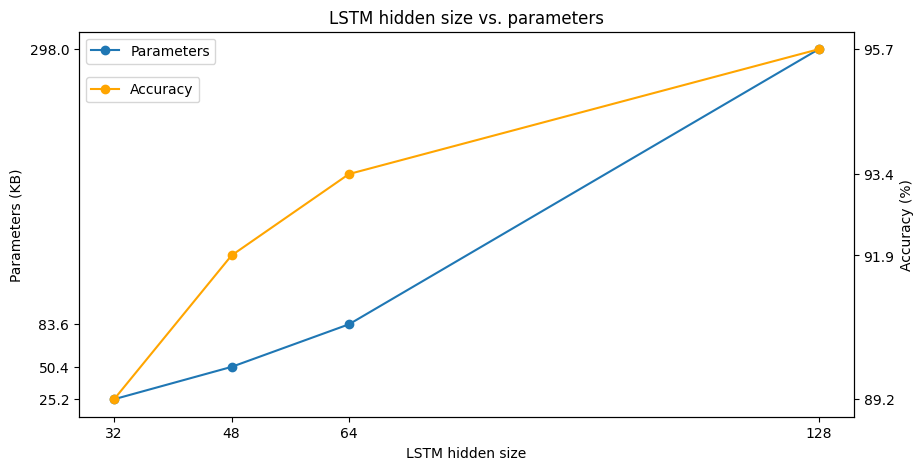

In [36]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(lstm_sizes, params, marker='o', label="Parameters")
ax.set_xlabel("LSTM hidden size")
ax.set_ylabel("Parameters (KB)")
ax.set_title("LSTM hidden size vs. parameters")
ax.set_xticks(lstm_sizes)
ax.set_xticklabels(lstm_sizes)
ax.set_yticks(params)
ax.set_yticklabels(np.array(params) * 4) # convert to KB
ax.legend(loc="upper left", )
ax2 = ax.twinx()
ax2.plot(lstm_sizes, avg_acc, marker='o', color='orange', label="Accuracy")
ax2.set_ylabel("Accuracy (%)")
ax2.set_yticks(avg_acc)
ax2.set_yticklabels([f"{a:.1f}" for a in avg_acc])
ax2.legend(loc="upper left", bbox_to_anchor=(0., 0.9))


plt.show()
# save the model
